# Extended HPS domain
I found that nudging a gaussian bump close to the boundary of the domain can significantly degrade the quality of the HPS's solution, both in the near- and far-field cases. So, I think it would be a good idea to allow for a larger computational domain for HPS to run on compared with the uniform grid from the input.

In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.2"
# os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

import jax
import jax.numpy as jnp
import numpy as np
from scipy.io import savemat
import matplotlib.pyplot as plt

from timeit import default_timer
import logging
logging.basicConfig(
    format="%(asctime)s.%(msecs)03d:jaxhps: %(levelname)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level=logging.DEBUG
)

from examples.wave_scattering_utils import (
    solve_scattering_problem,
    load_SD_matrices,
    get_uin,
)
from examples.scattering_potentials import (
    q_gaussian_bumps,
)
from examples.plotting_utils import plot_field_for_wave_scattering_experiment

jax.config.update("jax_default_device", jax.devices("gpu")[0])
jax.config.update("jax_enable_x64", True)
# jax.config.update("XLA_PYTHON_CLIENT_MEM_FRACTION", 0.5)


import subprocess
_ =subprocess.run("hostname")
_ =subprocess.run(["nvidia-smi", "--query-gpu=gpu_name,memory.total",  "--format=csv,noheader"])

2025-07-01 17:07:27.962:jaxhps: DEBUG - Creating converter from 7 to 5
2025-07-01 17:07:27.964:jaxhps: DEBUG - Creating converter from 5 to 7
2025-07-01 17:07:27.965:jaxhps: DEBUG - Creating converter from 7 to 5
2025-07-01 17:07:27.966:jaxhps: DEBUG - Creating converter from 5 to 7


g14.ttic.edu
NVIDIA RTX A6000, 49140 MiB


In [2]:
from src.jaxhps import (
    DiscretizationNode2D,
    Domain,
    PDEProblem,
    upward_pass_subtree,
    downward_pass_subtree,
    local_solve_chunksize_2D,
)
from src.jaxhps.local_solve import local_solve_stage_uniform_2D_ItI
from src.jaxhps.merge import merge_stage_uniform_2D_ItI
from src.jaxhps.down_pass import down_pass_uniform_2D_ItI
from examples.wave_scattering_utils import (
    get_DtN_from_ItI,
    setup_scattering_lin_system,
    get_uin_and_normals,
    get_uin,
    get_scattering_uscat_impedance,
)

from src.wave_scattering.interp_utils import (
    prep_grids_cheb_2d,
    prep_grids_unif_2d,
    reorder_tree_cheb_for_hps,
)

from src.wave_scattering.interp_ops import (
    QuadtreeToUniform,
    UniformToQuadtree,
)

In [3]:
bump_center = jnp.array([0.05, 0.1])
# bump_center = jnp.array([0.0, 0.0])
amplitude = 2
sigma = 0.15
# sigma = 0.07
q_fn_handle = lambda x: amplitude * jnp.exp(-0.5*jnp.sum( ((x-bump_center)/sigma)**2 ,axis=-1))

# q_fn_handle = lambda x: q_gaussian_bumps(1.5 * x)

In [4]:
tree_n_per_leaf = 32
tree_L = 2
tree_p = 16
tree_n = 2**tree_L * tree_n_per_leaf
clip_n = 60

clip_domain_bounds = jnp.array([-0.5, 0.5, -0.5, 0.5])
quad_domain_bounds  = jnp.array([-1., 1., -1., 1.])
tree_root = DiscretizationNode2D(*quad_domain_bounds)
tree_domain = Domain(p=tree_p, q=tree_p-2, root=tree_root, L=tree_L)

clip_root = DiscretizationNode2D(*clip_domain_bounds)
clip_domain = Domain(p=tree_p, q=tree_p-2, root=clip_root, L=tree_L)

print(f"L={tree_L}, N={tree_n}")

L=2, N=128


In [5]:
# Grid setup
cell_offset = 0

# leaf-level
leaf_cheb_grids = prep_grids_cheb_2d(0, tree_p, quad_domain_bounds)
leaf_cheb_x  = leaf_cheb_grids[0]
leaf_cheb_y  = leaf_cheb_grids[1]
leaf_cheb_xy = leaf_cheb_grids[2]
leaf_unif_grids = prep_grids_unif_2d(0, tree_n_per_leaf, clip_domain_bounds, rel_offset=cell_offset)
leaf_unif_x  = leaf_unif_grids[0]
leaf_unif_y  = leaf_unif_grids[1]
leaf_unif_xy = leaf_unif_grids[2]

# Tree level
tree_quad_cheb_grids = prep_grids_cheb_2d(tree_L, tree_p, quad_domain_bounds)
tree_quad_cheb_x  = tree_quad_cheb_grids[0]
tree_quad_cheb_y  = tree_quad_cheb_grids[1]
tree_quad_cheb_xy = tree_quad_cheb_grids[2]

tree_quad_unif_grids = prep_grids_unif_2d(tree_L, tree_n_per_leaf, quad_domain_bounds, rel_offset=cell_offset)
tree_quad_unif_x  = tree_quad_unif_grids[0]
tree_quad_unif_y  = tree_quad_unif_grids[1]
tree_quad_unif_xy = tree_quad_unif_grids[2]

tree_clip_unif_grids = prep_grids_unif_2d(0, clip_n, clip_domain_bounds, rel_offset=cell_offset)
tree_clip_unif_x  = tree_clip_unif_grids[0]
tree_clip_unif_y  = tree_clip_unif_grids[1]
tree_clip_unif_xy = tree_clip_unif_grids[2]

hps_cheb_xy = reorder_tree_cheb_for_hps(tree_quad_cheb_xy, tree_L, tree_p)

In [6]:
# 0. Compute reference values
ref_q_tree_unif = q_fn_handle(tree_quad_unif_xy).reshape(tree_n, tree_n) # .reshape(4**tree_L, -1)
ref_q_clip_unif = q_fn_handle(tree_clip_unif_xy).reshape(clip_n, clip_n)
ref_q_tree_cheb = q_fn_handle(tree_domain.interior_points).reshape(4**tree_L, -1)

In [7]:
%%time
tree_QtU = QuadtreeToUniform(
    tree_L, tree_p, tree_n_per_leaf, clip_n,
    quad_domain_bounds=quad_domain_bounds,
    clip_domain_bounds=clip_domain_bounds,
    rel_offset=0,
)
print(f"Can clip via slicing? {'Yes' if tree_QtU.use_slice else 'No'}")

Can clip via slicing? No
CPU times: user 1.36 s, sys: 64.1 ms, total: 1.42 s
Wall time: 1.86 s


In [8]:
%%time
tree_UtQ = UniformToQuadtree(
    tree_L, tree_p, clip_n,
    clip_domain_bounds,
    quad_domain_bounds,
    rel_offset=0
)

CPU times: user 4.04 s, sys: 660 ms, total: 4.7 s
Wall time: 2.18 s


In [9]:
# 1. Check the Uniform -> Quadtree error...
tree_q_utq = tree_UtQ.apply(ref_q_clip_unif)
tree_utq_err = jnp.linalg.norm(ref_q_tree_cheb - tree_q_utq) / jnp.linalg.norm(ref_q_tree_cheb)
print(f"Uniform->Quadtree relative error: {tree_utq_err:.5e}")

Uniform->Quadtree relative error: 2.01256e-02


In [10]:
# 2. Check Quadtree (reference) -> clipped Uniform 
tree_q_qtu_quad, tree_q_qtu_clip = tree_QtU.apply(ref_q_tree_cheb, output_mode="both")
tree_qtu_err = jnp.linalg.norm(ref_q_clip_unif - tree_q_qtu_clip) / jnp.linalg.norm(ref_q_clip_unif)
print(f"Uniform->Quadtree relative error: {tree_qtu_err:.5e}")

Uniform->Quadtree relative error: 2.70726e-05


In [11]:
# 3. Check Uniform -> Quadtree -> clipped Uniform 
tree_q_utqtu = tree_QtU.apply(tree_q_utq, output_mode="clip")
tree_utqtu_err = jnp.linalg.norm(ref_q_clip_unif - tree_q_utqtu) / jnp.linalg.norm(ref_q_clip_unif)
print(f"Uniform->Quadtree relative error: {tree_utqtu_err:.5e}")

Uniform->Quadtree relative error: 1.64198e-03


## Try re-writing the barycentric lagrange interpolation matrix to vectorize it

In [12]:
from src.jaxhps.quadrature import (
    chebyshev_points,
    gauss_points,
    # barycentric_lagrange_interpolation_matrix_1D as ref_blim_1d,
)
test_p = 16
cheby_pts = chebyshev_points(test_p)
gauss_pts = gauss_points(test_p-2)

# @jax.jit
def ref_blim_1d(from_pts: jax.Array, to_pts: jax.Array) -> jax.Array:
    p = from_pts.shape[0]
    n = to_pts.shape[0]

    w = jnp.ones(p, dtype=jnp.float64)
    for j in range(p):
        for k in range(p):
            if j != k:
                w = w.at[j].mul(from_pts[j] - from_pts[k])

    # Normalizing factor is sum_j w_j / (x - x_j)
    # (2025-07-01, OOT) Vectorized version
    norm_factors = jnp.zeros(n, dtype=jnp.float64)
    for i in range(p):
        norm_factors += 1 / (w[i] * (to_pts - from_pts[i]))

    # Compute the matrix
    matrix = jnp.zeros((n, p), dtype=jnp.float64)
    for i in range(n):
        for j in range(p):
            matrix = matrix.at[i, j].set(
                1 / ((to_pts[i] - from_pts[j]) * w[j] * norm_factors[i])
            )
    # Check if any of the source and target points overlap
    # This code is semantically the same as what comes after.
    # The code below is vectorized and is able to be compiled because it does not
    # use the conditionals on to_pts and from_pts.

    # Create a boolean mask for matching points
    matches = to_pts[:, None] == from_pts[None, :]  # Shape: (n, p)

    # Create row masks for any matching points
    has_match = matches.any(axis=1)  # Shape: (n,)

    # Update the matrix
    matrix = jnp.where(
        has_match[:, None],  # Broadcasting to shape (n, p)
        jnp.where(
            matches,
            1.0,  # Where points match
            0.0,  # Where points don't match but row has a match
        ),
        matrix,  # Keep original values where row has no matches
    )

    return matrix

def nb_blim_1d(from_pts: jax.Array, to_pts: jax.Array) -> jax.Array:
    p = from_pts.shape[0]
    n = to_pts.shape[0]

    # (2025-07-01, OOT) Vectorized version
    from_di = jnp.arange(p) # for use as diagonal indices for from_pts_x
    tmp_from_dist = from_pts[:, jnp.newaxis] - from_pts[jnp.newaxis, :]
    tmp_from_dist = tmp_from_dist.at[from_di,from_di].set(1)
    w = jnp.prod(tmp_from_dist, axis=0)

    # Normalizing factor is sum_j w_j / (x - x_j)
    # (2025-07-01, OOT) Vectorized version
    norm_factors = jnp.zeros(n, dtype=jnp.float64)
    norm_factors = jnp.sum(
        1 / (
            w[:, jnp.newaxis] * (to_pts[jnp.newaxis, :] - from_pts[:, jnp.newaxis])
        ),
        axis = 0,
    )

    # Compute the matrix
    # (2025-07-01, OOT) Vectorized version
    matrix = 1/ (
        (to_pts[:, jnp.newaxis] - from_pts[jnp.newaxis, :])
        * w[jnp.newaxis, :] * norm_factors[:, jnp.newaxis]
    )
    # Check if any of the source and target points overlap
    # This code is semantically the same as what comes after.
    # The code below is vectorized and is able to be compiled because it does not
    # use the conditionals on to_pts and from_pts.

    # Create a boolean mask for matching points
    matches = to_pts[:, None] == from_pts[None, :]  # Shape: (n, p)

    # Create row masks for any matching points
    has_match = matches.any(axis=1)  # Shape: (n,)

    # Update the matrix
    matrix = jnp.where(
        has_match[:, None],  # Broadcasting to shape (n, p)
        jnp.where(
            matches,
            1.0,  # Where points match
            0.0,  # Where points don't match but row has a match
        ),
        matrix,  # Keep original values where row has no matches
    )

    return matrix

In [13]:
%%time
ref_blim_mat = ref_blim_1d(gauss_pts, cheby_pts)

CPU times: user 2.52 s, sys: 466 ms, total: 2.99 s
Wall time: 2.16 s


In [14]:
%%time
nb_blim_mat = nb_blim_1d(gauss_pts, cheby_pts)

CPU times: user 758 ms, sys: 71.8 ms, total: 829 ms
Wall time: 1.3 s


In [15]:
jnp.all(ref_blim_mat == nb_blim_mat).item()

True

In [16]:
# from src.jaxhps.quadrature._interpolation import barycentric_lagrange_interpolation_matrix_3D as blim3d
# ref_blim3d_mat = blim3d(gauss_pts, 3+gauss_pts, 7+gauss_pts, cheby_pts, 10+cheby_pts, 13+cheby_pts, vectorized=False)
# vec_blim3d_mat = blim3d(gauss_pts, 3+gauss_pts, 7+gauss_pts, cheby_pts, 10+cheby_pts, 13+cheby_pts, vectorized=True)

### Try with the HPS solver...

In [17]:
from exterior_solver.utils.ScatteringProblem import ScatteringProblem
from exterior_solver.utils.gen_SD_exterior import (
    gen_D_exterior,
    gen_S_exterior,
)
from exterior_solver.exterior_solver_for_Olivia import (
    get_uscat_and_dn,
    forward_model_exterior,
)

In [18]:
# Basic problem dimensions
k_str = "20"
k = float(k_str)
R = 100

N_x = 192
N_x_quad = N_x * 2 # extended domain for HPS to operate on
L = 3
p = 16 # chebyshev order
pm2 = p-2 # gauss-legendre order
n_per_leaf = int(np.round(N_x_quad / (2**L)))
nside = 2**L
n = nside * n_per_leaf

N_s = 192
N_r = N_s
source_dirs = jnp.pi/2-jnp.linspace(0, 2*jnp.pi, N_s, endpoint=False)
# source_dirs = jnp.linspace(0, 2*jnp.pi, N_s, endpoint=False)

# q_fn = lambda x: q_gaussian_bumps(0.7*x)
q_fn = q_fn_handle
main_clip_domain_bounds = jnp.array([-0.5, 0.5, -0.5, 0.5])
# main_clip_root = DiscretizationNode2D(*main_clip_domain_bounds)
# main_clip_domain = Domain(p=p, q=p-2, root=main_clip_root, L=L) # Smaller grid
main_clip_unif_x, main_clip_unif_y, main_clip_unif_xy = prep_grids_unif_2d(
    0, N_x,
    main_clip_domain_bounds,
    rel_offset=0
)

main_quad_domain_bounds = jnp.array([-1., 1., -1., 1.])
main_quad_root = DiscretizationNode2D(*main_quad_domain_bounds)
main_quad_domain = Domain(p=p, q=p-2, root=main_quad_root, L=L) # Extended grid

main_quad_unif_x, main_quad_unif_y, main_quad_unif_xy = prep_grids_unif_2d(
    L, n_per_leaf,
    main_quad_domain_bounds,
    rel_offset=0
)
main_cheb_x, main_cheb_y, main_cheb_xy = prep_grids_cheb_2d(L, p, main_quad_domain_bounds)
main_hps_cheb_xy = reorder_tree_cheb_for_hps(main_cheb_xy, L, p)

ref_main_q_cheb = q_fn(main_quad_domain.interior_points)
ref_main_q_quad_unif = q_fn(main_quad_unif_xy).reshape(N_x_quad, N_x_quad)
ref_main_q_clip_unif = q_fn(main_clip_unif_xy).reshape(N_x, N_x)

In [19]:
# Load S and D matrices for the boundary integral equation
S_D_matrices_fp = os.path.join(
    "data/wave_scattering/SD_matrices",
    f"SD_k{k_str}_n{pm2}_nside{nside}_dom1.mat"
)
S_int, D_int = load_SD_matrices(S_D_matrices_fp)

# Generate the exterior S, D matrices
S_ext = gen_S_exterior(domain=main_quad_domain, k=k, rad=R, source_dirs=source_dirs)
D_ext = gen_D_exterior(domain=main_quad_domain, k=k, rad=R, source_dirs=source_dirs)

In [20]:
from typing import Tuple
class HPSScatteringSolver():
    def __init__(
        self, 
        L, p, unif_n, k,
        S_int, D_int,
        source_dirs=None,
        receiver_dirs=None,
        S_ext=None, D_ext=None,
        N_r=None, N_s=None, receiver_radius=100,
        unif_domain_bounds=(-0.5, 0.5, -0.5, 0.5),
        quad_domain_bounds=(-0.5, 0.5, -0.5, 0.5),
        UtQ=None,
        # QtU=None,
    ):
        """Set up the HPS solver
        """
        self.L = L
        self.p = p
        # self.n_per_leaf = n_per_leaf
        # self.n = 2**L * n_per_leaf
        self.n = unif_n
        self.n_per_leaf = unif_n // 2**L
        self.k = k
        self.receiver_radius = receiver_radius

        self.leaf_bounds = (-1., 1., -1., 1.)
        self.unif_domain_bounds = jnp.array(unif_domain_bounds)
        self.quad_domain_bounds = jnp.array(quad_domain_bounds)
        self.root = DiscretizationNode2D(*self.quad_domain_bounds)
        self.domain = Domain(p=p, q=p - 2, root=self.root, L=L)

        # Calculate the grids in case they'll be useful later...
        self.leaf_unif_x, self.leaf_unif_y, self.leaf_unif_xy = prep_grids_unif_2d(
            0, self.n_per_leaf, domain_bounds=self.leaf_bounds, rel_offset=0,
        )
        self.leaf_cheb_x, self.leaf_cheb_y, self.leaf_cheb_xy = prep_grids_cheb_2d(
            0, self.p, domain_bounds=self.leaf_bounds
        )
        self.tree_unif_x, self.tree_unif_y, self.tree_unif_xy = prep_grids_unif_2d(
            0, self.n, domain_bounds=self.unif_domain_bounds, rel_offset=0,
        )
        self.tree_cheb_x, self.tree_cheb_y, self.tree_cheb_xy = prep_grids_cheb_2d(
            self.L, self.p, domain_bounds=self.quad_domain_bounds
        )

        # Expect N_r or receiver_dirs and N_s or source_dirs
        # If both are given but conflict, the values from the {source,receiver}_dirs will be used
        assert not (N_r is None and receiver_dirs is None)
        assert not (N_s is None and source_dirs is None)
        self.N_r = N_r if N_r is not None else receiver_dirs.shape[0]
        self.N_s = N_s if N_s is not None else source_dirs.shape[0]
        self.receiver_dirs = receiver_dirs if receiver_dirs is not None else \
            jnp.pi/2-jnp.linspace(0, 2*jnp.pi, self.N_r, endpoint=False)
        self.source_dirs = source_dirs if source_dirs is not None else \
            jnp.pi/2-jnp.linspace(0, 2*jnp.pi, self.N_s, endpoint=False)

        # Save the interior S, D matrices
        self.S_int = S_int
        self.D_int = D_int

        # Compute the exterior S, D matrices in case they were not already passed
        self.S_ext = S_ext if S_ext is not None else \
            gen_S_exterior(
                domain=self.domain,
                k=k,
                rad=receiver_radius,
                source_dirs=self.receiver_dirs
            )
        self.D_ext = D_ext if D_ext is not None else \
            gen_D_exterior(
                domain=self.domain,
                k=k,
                rad=receiver_radius,
                source_dirs=self.receiver_dirs
            )

        # Set up the PDE Problem object
        self.d_xx_evals = jnp.ones_like(self.domain.interior_points[..., 0])
        self.d_yy_evals = jnp.ones_like(self.domain.interior_points[..., 0])
        self.pde_problem = PDEProblem(
            domain=self.domain,
            D_xx_coefficients=self.d_xx_evals,
            D_yy_coefficients=self.d_yy_evals,
            eta=self.k,
            use_ItI=True,
        )

        # Set up the Scattering Problem object
        self.scat_problem = ScatteringProblem(
            pde_problem=self.pde_problem,
            S_int=self.S_int,
            D_int=self.D_int,
            S_ext=self.S_ext,
            D_ext=self.D_ext,
            target_points_reg=None,
            source_dirs=self.source_dirs,
        )
        self.UtQ = UtQ if UtQ is not None else \
            UniformToQuadtree(
                self.L, self.p, self.n,
                self.unif_domain_bounds,
                self.quad_domain_bounds,
                rel_offset=0,
            )
        # # in case I need this later...
        # self.QtU = QtU if QtU is not None else \
        #     QuadtreeToUniform(
        #         self.L, self.p, self.n_per_leaf, self.n,
        #         quad_domain_bounds=self.quad_domain_bounds,
        #         clip_domain_bounds=self.clip_domain_bounds,
        #         rel_offset=0,
        #     )

    def solve_exterior(self, q: jax.Array, quadtree_in=False) -> Tuple[jax.Array]:
        """Solve for uscat on the exterior for the values at the receivers
        Note: returns usc_ext_hps and also d_rs, which has its axes flipped
        to match the format of the Lippmann-Schwinger solver's outputs
        Returns both to hopefully reduce the chance of confusion later on...
        """
        q_quadtree = q if quadtree_in else self.UtQ.apply(q)
        usc_ext_hps = forward_model_exterior(
            scattering_problem=self.scat_problem, q=q_quadtree,
        )
        d_rs_hps = usc_ext_hps.T
        logging.info(f"Returning usc_ext_hps and d_rs_hps")
        return usc_ext_hps, d_rs_hps

    def solve_interior(self, q: jax.Array) -> Tuple[jax.Array]:
        """Solve for uscat on the interior of the domain
        Not implemented so far...
        """
        pass
        

In [21]:
%%time
hps_scattering_solver_original = HPSScatteringSolver(
    L=L, p=p, unif_n=N_x, k=k,
    S_int=S_int,
    D_int=D_int,
    N_r=N_r,
    N_s=N_s,
    unif_domain_bounds = (-0.5, 0.5, -0.5, 0.5),
    quad_domain_bounds = (-0.5, 0.5, -0.5, 0.5),
    # UtQ=main_UtQ, # optional
)

2025-07-01 17:07:54.603:jaxhps: INFO - ScatteringProblem: cheby_weights_2D_rearranged shape: (1, 256)
2025-07-01 17:07:54.683:jaxhps: INFO - ScatteringProblem: self.quad_weights_hps shape: (64, 256)
2025-07-01 17:07:54.684:jaxhps: INFO - ScatteringProblem: self.pde_problem.domain.interior_points.shape: (64, 256, 2)


CPU times: user 4.57 s, sys: 421 ms, total: 4.99 s
Wall time: 4.48 s


In [22]:
%%time
# Likely to run faster but only because it's not dealing with the compilation time
hps_scattering_solver_extended = HPSScatteringSolver(
    L=L, p=p, unif_n=N_x, k=k,
    S_int=S_int,
    D_int=D_int,
    N_r=N_r,
    N_s=N_s,
    unif_domain_bounds = (-0.5, 0.5, -0.5, 0.5),
    quad_domain_bounds = (-1., 1., -1., 1.),
    # UtQ=main_UtQ, # optional
)

2025-07-01 17:07:56.328:jaxhps: INFO - ScatteringProblem: cheby_weights_2D_rearranged shape: (1, 256)
2025-07-01 17:07:56.330:jaxhps: INFO - ScatteringProblem: self.quad_weights_hps shape: (64, 256)
2025-07-01 17:07:56.331:jaxhps: INFO - ScatteringProblem: self.pde_problem.domain.interior_points.shape: (64, 256, 2)


CPU times: user 10.4 s, sys: 2.51 s, total: 13 s
Wall time: 5.57 s


In [23]:
%%time
_, d_rs_hps_original = hps_scattering_solver_original.solve_exterior(ref_main_q_clip_unif)

2025-07-01 17:08:01.551:jaxhps: INFO - Starting exterior solve...
2025-07-01 17:08:01.554:jaxhps: INFO - Building the solver...
2025-07-01 17:08:03.014:jaxhps: DEBUG - merge_stage_uniform_2D_ItI: T_arr.shape = (64, 56, 56)
2025-07-01 17:08:07.607:jaxhps: INFO - Computing DtN from ItI...
2025-07-01 17:08:07.815:jaxhps: INFO - Computing uin and uin_dn on the boundary
2025-07-01 17:08:08.052:jaxhps: INFO - Computing uscat values and normal derivatives on the boundary...
2025-07-01 17:08:08.053:jaxhps: INFO - Setting up the scattering linear equations...
2025-07-01 17:08:08.708:jaxhps: INFO - Solving the system... (A.shape=(448, 448); b.shape=(448, 192))
2025-07-01 17:08:08.921:jaxhps: INFO - Post-processing the system
2025-07-01 17:08:09.062:jaxhps: INFO - Mapping to exterior points...
2025-07-01 17:08:09.145:jaxhps: INFO - Finished and returning!
2025-07-01 17:08:09.228:jaxhps: INFO - Returning usc_ext_hps and d_rs_hps


CPU times: user 6.61 s, sys: 318 ms, total: 6.93 s
Wall time: 7.72 s


In [24]:
%%time
# Similarly, this is expected to be faster since it does not deal with first-time JIT compilation
_, d_rs_hps_extended = hps_scattering_solver_extended.solve_exterior(ref_main_q_clip_unif)

2025-07-01 17:08:09.261:jaxhps: INFO - Starting exterior solve...
2025-07-01 17:08:09.263:jaxhps: INFO - Building the solver...
2025-07-01 17:08:09.270:jaxhps: DEBUG - merge_stage_uniform_2D_ItI: T_arr.shape = (64, 56, 56)
2025-07-01 17:08:09.312:jaxhps: INFO - Computing DtN from ItI...
2025-07-01 17:08:09.314:jaxhps: INFO - Computing uin and uin_dn on the boundary
2025-07-01 17:08:09.315:jaxhps: INFO - Computing uscat values and normal derivatives on the boundary...
2025-07-01 17:08:09.316:jaxhps: INFO - Setting up the scattering linear equations...
2025-07-01 17:08:09.318:jaxhps: INFO - Solving the system... (A.shape=(448, 448); b.shape=(448, 192))
2025-07-01 17:08:09.320:jaxhps: INFO - Post-processing the system
2025-07-01 17:08:09.321:jaxhps: INFO - Mapping to exterior points...
2025-07-01 17:08:09.323:jaxhps: INFO - Finished and returning!
2025-07-01 17:08:09.324:jaxhps: INFO - Returning usc_ext_hps and d_rs_hps


CPU times: user 76.8 ms, sys: 23.1 ms, total: 100 ms
Wall time: 83.7 ms


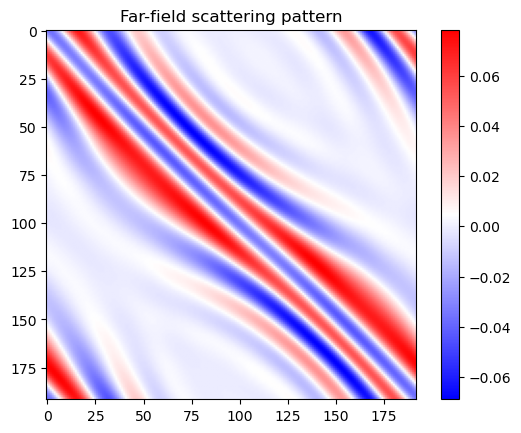

In [25]:
plt.title("Far-field scattering pattern")
plt.imshow(jnp.real(d_rs_hps_extended), cmap="bwr")
plt.colorbar()
plt.show()

## Compare against Lippmann-Schwinger

In [26]:
import torch
import scipy.sparse.linalg
import sys, os, importlib.util

def module_importer(module_name, target_path):
    # See https://stackoverflow.com/questions/67631/how-can-i-import-a-module-dynamically-given-the-full-path
    target_path = os.path.abspath(os.path.expanduser(target_path))
    spec = importlib.util.spec_from_file_location(module_name, target_path)
    module = importlib.util.module_from_spec(spec)
    sys.modules[module_name] = module
    spec.loader.exec_module(module)
    return module

solvers = module_importer ("solvers", "~/rlc-repo/solvers/__init__.py")
src = module_importer ("src", "~/rlc-repo/src/__init__.py")
from solvers.integral_equation.HelmholtzSolverDifferentiable import (
    setup_differentiable_solver,
    HelmholtzSolverDifferentiable,
    PytorchPDESolver,
    NP_CDTYPE, TORCH_CDTYPE, TORCH_RDTYPE,
)

from src.utils.plotting_utils import plot_row
from src.utils.vram_info import get_memory_info, free_vram
from src.data.data_io import load_hdf5_to_dict, load_multifreq_dataset

import os
import sys
import time
# import tqdm
import logging
from typing import Tuple, Callable, Dict
import IPython
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

get_memory_info()

import subprocess
_ = subprocess.run("hostname")
_ = subprocess.run(["nvidia-smi", "--query-gpu=gpu_name,memory.total",  "--format=csv,noheader"])

RAM Used (MB): 8983
VRAM (MB): 0 free of 0 reserved; 0 allocated out of 48669 total
g14.ttic.edu
NVIDIA RTX A6000, 49140 MiB


In [27]:
nu_solver  = k / (2*np.pi)
spatial_domain_max = 0.5
receiver_radius = R
q_si  = np.array(ref_main_q_clip_unif)

print(f"Use frequency {nu_solver}*2pi")
solver_obj = setup_differentiable_solver(
    N_x, spatial_domain_max, nu_solver, receiver_radius,
    prepare_half_grid=True, device=device,
)

Use frequency 3.183098861837907*2pi
Calling find_diag_correction(h=5.2083e-03, frequency=20.00)...
Calling find_diag_correction(h=1.0417e-02, frequency=20.00)...


In [28]:
get_memory_info()
free_vram()
get_memory_info()

RAM Used (MB): 9191
VRAM (MB): 1955 free of 2080 reserved; 124 allocated out of 48669 total
RAM Used (MB): 9190
VRAM (MB): 35 free of 160 reserved; 124 allocated out of 48669 total


In [29]:
restart = 2000 # 0 # 1000 # try not restarting...
batch_size = 96
max_iter = 20_000

rtol_ref = 1e-6
verbose = False

# Extra evaluation information
uin = solver_obj._get_uin(torch.tensor(solver_obj.source_dirs, device=device))
uin_int_ls = jnp.array(uin.detach().cpu().numpy()).T.reshape(N_x, N_x, N_s)

tq_si = torch.tensor(q_si, dtype=torch.float, device=device, requires_grad=False)
tqf_si = tq_si.flatten().unsqueeze(-1) # flattened
b_si  = -(solver_obj.frequency**2 * tqf_si * uin.permute(1, 0)).to(TORCH_CDTYPE)

def _matvec_from_torch_si(x: torch.Tensor, so=solver_obj) -> torch.Tensor:
    g_out = so._G_apply(x)
    y = x + (so.frequency**2 * tqf_si * g_out).to(TORCH_CDTYPE)
    return y

t0 = time.perf_counter()
d_rs_ref, sigma_ref = solver_obj.Helmholtz_solve_exterior_batched(
    tq_si,
    batch_size=batch_size,
    rtol=rtol_ref,
    linsys_solver="bicgstab",
    max_iter=max_iter,
    return_as_torch=False,
    return_sigma=True,
    error_unless_converged=False,
    convergence_by_dir=True,
    use_half_grid=True, # try not to boost the accuracy too much
    half_grid_tol_ratio=1,
    report_status=True,
    verbose=verbose,
    restart=restart,
)
t1 = time.perf_counter()
usc_ext_ls = jnp.array(d_rs_ref) # .T
usc_int_ls = jnp.array(
    solver_obj._G_apply(torch.tensor(sigma_ref,device=device).T)
    .reshape(N_x, N_x, N_s)
    .detach().cpu().numpy()
)
utot_int_ls = usc_int_ls + uin_int_ls

Asig_ref   = _matvec_from_torch_si(torch.tensor(sigma_ref, device=device).T)
resid_ref  = torch.norm( Asig_ref - b_si , dim=0 ) / torch.norm(b_si, dim=0)
resid_ref_min = resid_ref.min().item()
resid_ref_max = resid_ref.max().item()
print(f"BiCGSTAB at rtol={rtol_ref:.2e}: PDE solver ran for {t1-t0:.2f}s")
print(f"Relative residuals range between {resid_ref_min:.3e} to {resid_ref_max:.3e}")

2025-07-01 17:08:17.011:jaxhps: DEBUG - _solve_Helmholtz_inv: starting (using bicgstab)
2025-07-01 17:08:17.168:jaxhps: INFO - bicgstab exited after 14 iterations with status optimal
2025-07-01 17:08:17.169:jaxhps: DEBUG - _solve_Helmholtz_inv: returning
2025-07-01 17:08:17.226:jaxhps: DEBUG - _solve_Helmholtz_inv: starting (using bicgstab)


bicgstab exited after 14 iterations with status optimal


2025-07-01 17:08:17.514:jaxhps: INFO - bicgstab exited after 9 iterations with status optimal
2025-07-01 17:08:17.515:jaxhps: DEBUG - _solve_Helmholtz_inv: returning
2025-07-01 17:08:17.517:jaxhps: DEBUG - _solve_Helmholtz_inv: starting (using bicgstab)
2025-07-01 17:08:17.624:jaxhps: INFO - bicgstab exited after 14 iterations with status optimal
2025-07-01 17:08:17.625:jaxhps: DEBUG - _solve_Helmholtz_inv: returning
2025-07-01 17:08:17.682:jaxhps: DEBUG - _solve_Helmholtz_inv: starting (using bicgstab)


bicgstab exited after 9 iterations with status optimal
bicgstab exited after 14 iterations with status optimal


2025-07-01 17:08:17.976:jaxhps: INFO - bicgstab exited after 9 iterations with status optimal
2025-07-01 17:08:17.977:jaxhps: DEBUG - _solve_Helmholtz_inv: returning


bicgstab exited after 9 iterations with status optimal
BiCGSTAB at rtol=1.00e-06: PDE solver ran for 1.02s
Relative residuals range between 1.505e-07 to 9.862e-07


In [30]:
d_rs_err_original = np.linalg.norm((d_rs_hps_original - d_rs_ref)) / np.linalg.norm((d_rs_ref))
print(f"Relative error (original quadtree): {d_rs_err_original:.5e}")

Relative error (original quadtree): 4.87796e-02


In [31]:
d_rs_err_extended = np.linalg.norm((d_rs_hps_extended - d_rs_ref)) / np.linalg.norm((d_rs_ref))
print(f"Relative error (original quadtree): {d_rs_err_extended:.5e}")

Relative error (original quadtree): 1.94595e-04


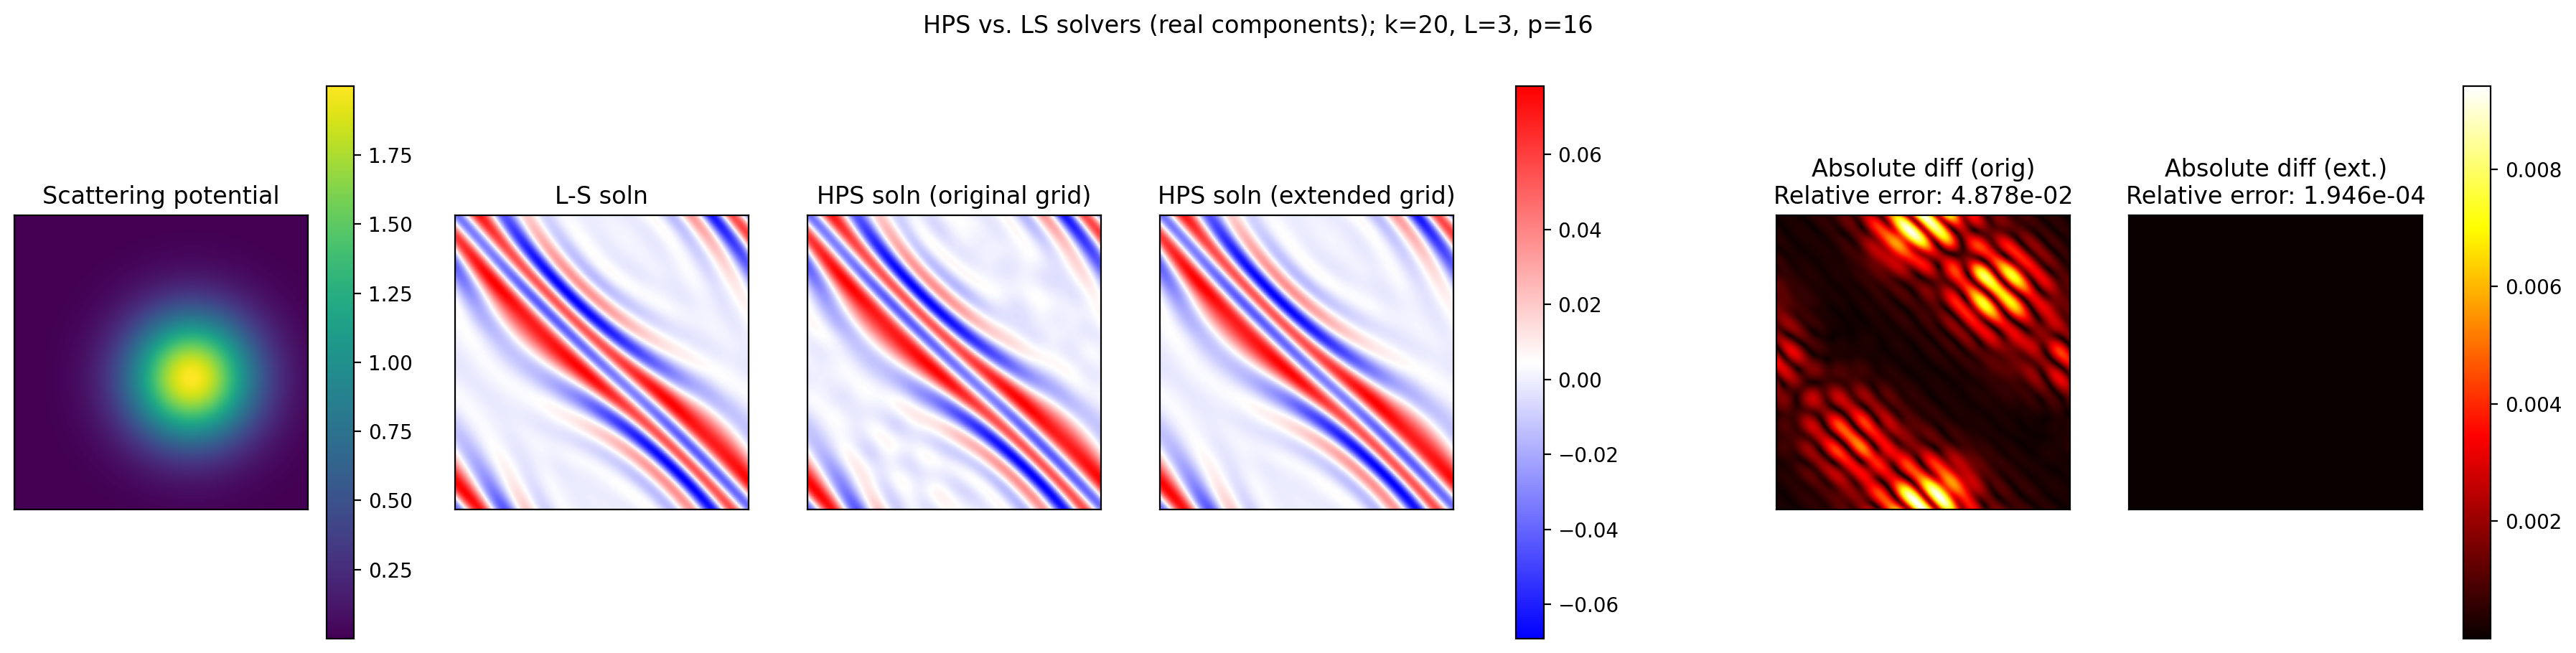

In [32]:
fig, axes = plot_row(
    [
        ref_main_q_clip_unif,
        jnp.real(d_rs_ref),
        jnp.real(d_rs_hps_original),
        jnp.real(d_rs_hps_extended),
        jnp.abs(d_rs_hps_original-d_rs_ref),
        jnp.abs(d_rs_hps_extended-d_rs_ref),
    ],
    [
        "Scattering potential",
        "L-S soln",
        "HPS soln (original grid)",
        "HPS soln (extended grid)",
        f"Absolute diff (orig)\nRelative error: {d_rs_err_original:.3e}",
        f"Absolute diff (ext.)\nRelative error: {d_rs_err_extended:.3e}",
    ],
    cmap_group_lens=[1,3,2],
    group_cmaps=["viridis", "bwr", "hot"],
    subplot_width=3.5,
    subplot_height=3,
    extra_fig_height=2,
    plt_subplots_kw={"dpi": 200},
)
fig.suptitle(f"HPS vs. LS solvers (real components); k={k_str}, L={L}, p={p}")
for ax in axes:
    ax.set_aspect(1)
plt.show()